## Grover Search and Quantum Amplitude Estimation 
Brassard et al ('96)

## GroverSearch Implementation

In [ ]:
## imports
from qiskit import *
from qiskit.algorithms import *
from qiskit import QuantumRegister, ClassicalRegister, QuantumCircuit
from qiskit import quantum_info, IBMQ, Aer
from qiskit import BasicAer
from qiskit.utils import QuantumInstance
# backend = BasicAer.get_backend("statevector_simulator")
# quantum_instance = QuantumInstance(backend)
from qiskit.algorithms import AmplitudeEstimation
#from qiskit.ignis.verification.tomography import state_tomography_circuits, StateTomographyFitter
from qiskit.visualization import plot_histogram, plot_state_qsphere, plot_bloch_multivector, plot_bloch_vector
import numpy as np
from numpy import pi
import seaborn as sns
from IPython.display import Image
import matplotlib.pyplot as plt


: 

In [ ]:
# setup simulator using IBM_id
# IBMQ.save_account("1c62e8a0d2b058d0e797db9c811bc34582df5553e25812301cd1518662c0ab68d2378ac6c197b65f8be944d04b7e7439f034e3926a44fa8088538b3d13782c1a", overwrite= True)
provider = IBMQ.load_account()
IBMQ.get_provider(hub='ibm-q-education', group='iit-madras-1', project='quantum-computin')
# setup required backends 
lima = provider.get_backend('ibmq_lima')
manila = provider.get_backend('ibmq_manila')
qsm_simulator = Aer.get_backend('qasm_simulator')
stv_simulator = Aer.get_backend('statevector_simulator')
aer = Aer.get_backend('aer_simulator')


: 

: 

: 

In [ ]:
## sub-routines for Grover Search ~
def to_oracle(pattern, name= 'oracle'):
    """ convert a given pattern to an oracle
    pattern~ a numpy vector with binarry entries """
    l = len(pattern)
    qr = QuantumRegister(l, name='reg')
    a = AncillaRegister(1, name='ancilla')
    qc = QuantumCircuit(qr, a, name= name+str(pattern))
    for q in range(l):
        if(pattern[q]==0): qc.x(qr[q])
    qc.x(a)
    qc.h(a)
    qc.mcx(qr, a)
    qc.h(a)
    qc.x(a)
    for q in range(l):
        if(pattern[q]==0): qc.x(qr[q])
    #qc.barrier()
    return qc.to_gate()

def diffuser(l):
    qr = QuantumRegister(l, name='reg')
    a = AncillaRegister(1, name='ancilla')
    circuit = QuantumCircuit(qr, a, name= 'Diff.')
    
    circuit.h(qr)
    circuit.x(qr)
    
    circuit.x(a)
    circuit.h(a)
    circuit.mcx(qr ,a)
    circuit.h(a)
    circuit.x(a)

    circuit.x(qr)
    circuit.h(qr)
          
    return circuit.to_gate()

def grover_iterate(qc, oracles, diffuser, qreg_u, ancilla, steps):
    for step in range(steps):
        for oracle in oracles:
            qc.append(oracle, list(range(qc.num_qubits)) )
        qc.append(diffuser, list([q for q in qreg_u])+ list(ancilla) )
        # qc.barrier()
    return qc


: 

: 

: 

In [ ]:
def run(patterns, grover_steps ):
    
    dim = len(patterns[0])
    # create oracles ~\
    oracles = []
    for pattern in patterns : oracles.append( to_oracle(pattern)) 
    
    # create diffuser ~\
    diff = diffuser(dim)
    # create circuit ~\
    
    qreg = QuantumRegister(dim, name= 'init')
    ancilla = AncillaRegister(1, name='ancilla')
    creg = ClassicalRegister(dim)
    qc = QuantumCircuit(qreg, creg, ancilla)
    qc.h(qreg)
    # run grover update steps ~\
    grover_iterate(qc, oracles, diff, qreg, ancilla,grover_steps)
    qc.measure(qreg, creg)
    
    job = execute(qc, backend= aer, shots= 1024)
    plot_histogram(job.result().get_counts())
    
    return qc, job


: 

: 

: 

In [ ]:
patterns = [[0,1,1],[0,1,0],[0,0,0]]

: 

: 

: 

In [ ]:
circuit, job = run(patterns,1)
circuit.draw()

┌───┐┌──────────────────┐┌──────────────────┐┌──────────────────┐»
 init_0: ┤ H ├┤0                 ├┤0                 ├┤0                 ├»
         ├───┤│                  ││                  ││                  │»
 init_1: ┤ H ├┤1                 ├┤1                 ├┤1                 ├»
         ├───┤│  oracle[0, 1, 1] ││  oracle[0, 1, 0] ││  oracle[0, 0, 0] │»
 init_2: ┤ H ├┤2                 ├┤2                 ├┤2                 ├»
         └───┘│                  ││                  ││                  │»
ancilla: ─────┤3                 ├┤3                 ├┤3                 ├»
              └──────────────────┘└──────────────────┘└──────────────────┘»
   c0: 3/═════════════════════════════════════════════════════════════════»
                                                                          »
«         ┌────────┐┌─┐      
« init_0: ┤0       ├┤M├──────
«         │        │└╥┘┌─┐   
« init_1: ┤1       ├─╫─┤M├───
«         │  Diff. │ ║ └╥┘┌─┐
« init_2: ┤2       ├─╫──╫─┤M├
«         │        │ ║  ║ └╥┘
«ancilla: ┤3       ├─╫──╫──╫─
«         └────────┘ ║  ║  ║ 
«   c0: 3/═══════════╩══╩══╩═
«                    0  1  2

: 

: 

: 

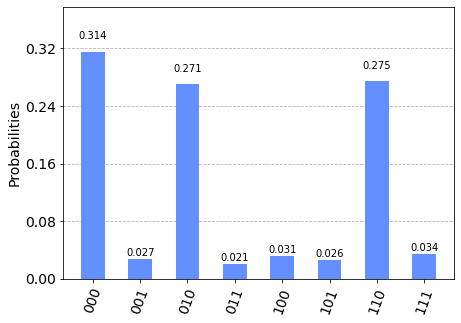

: 

: 

: 

In [ ]:
plot_histogram(job.result().get_counts())    

## QAE based on Quantum Phase Estimation

In [ ]:
## sub-routines for QPE ~
def crot(qc, l):
    if l == 0:
        return qc
    l = l-1
    qc.h(l)
    for q in range(l):
        qc.cp(pi/2**(l-q), q, l)
    #qc.barrier()
    # qc.draw()
    
def QFT(qc):
   """function to generate QFT circuit """
   dim = qc.num_qubits
   for q in range(dim):
      crot(qc, dim-q)
   for q in range(int(dim/2)):
      qc.swap(q, dim-q-1)

   #qc.draw()
   return qc
   

: 

: 

: 

In [ ]:
## sub-routine for grover ~
def grover(patterns, grover_steps):
    
    dim = len(patterns[0])
    
    # create oracles ~\
    oracles = []
    for pattern in patterns : oracles.append( to_oracle(pattern)) 
    
    # create diffuser ~\
    diff = diffuser(dim)

    # create circuit ~\
    qreg = QuantumRegister(dim, name= 'init')
    ancilla = AncillaRegister(1, name='ancilla')
    qc = QuantumCircuit(qreg, ancilla, name='grover'+'^'+str(grover_steps))
    qc = grover_iterate(qc, oracles, diff, qreg, ancilla,grover_steps)
  
    return qc

: 

: 

: 

## 1 qubit example : 
from https://github.com/Qiskit/qiskit-finance/blob/stable/0.3/docs/tutorials/00_amplitude_estimation.ipynb

Given the initial state is of form~
                    $\begin{equation} 
                    \ket{\psi_0} = \sqrt{1-p}\ket{0} + \sqrt{p}\ket{1}
                    \end{equation}$,
say, $\sqrt{p} = sin(\frac{\theta}{2})$ and $\sqrt{1-p} = cos(\frac{\theta}{2})\\$ 
Then the amplitude amplification process requires operator
$\begin{equation}
    \mathcal{Q} = -\mathcal{S}_{\ket{\psi_0}} \mathcal{S}_{\ket{1}}
\end{equation}$
where, $\mathcal{S}_{\ket{\psi_0}} and \mathcal{S}_{\ket{1}}$ are reflection operators about $\ket{\psi_0}$ and $\ket{1}$ respectively $\\$
Now $\mathcal{S}_{\ket{\psi_0}} = R_y(\theta)$, then 
 $\mathcal{Q} = cos(\theta) (\ket{0}\bra{0} + \ket{1}\bra{1}) + sin(\theta) (\ket{0}\bra{1} - \ket{1}\bra{0}) = R_{y}(2\theta) \\ $
 


In [ ]:
## set p ~
p = 0.8

## operator preparation ~
def s_psi0(p):
    qc = QuantumCircuit(1, name= " S_psi0 ")
    theta = 2*np.arcsin(np.sqrt(p))
    qc.ry(theta, 0)

    return qc.to_gate()
def Q(p, power):
    theta = 2*np.arcsin(np.sqrt(p))
    qc = QuantumCircuit(1, name= ' Q'+ '^'+ str(power) )
    qc.ry(2*theta*power, 0)

    return qc.to_gate()
    

: 

: 

: 

In [ ]:
precision = 4
preg = QuantumRegister(precision, name= 'precisio_q')
qreg = QuantumRegister(1, name='qreg')
creg = ClassicalRegister(precision, name='precision_c')
qc = QuantumCircuit(preg,qreg, creg)

qc.h(preg)
qc.append(s_psi0(p), [precision] )
qc.barrier()
for q in range(precision):
    qc.append(Q(p,2**q).control(1), [q]+list(range(precision,precision+1)) )

qftgate_inv = QFT(QuantumCircuit(precision, name='QFT')).to_gate().inverse()
qc.barrier()
qc.append(qftgate_inv, list(range(precision)))


qc.draw()

┌───┐     ░                                  ░ ┌─────────┐
 precisio_q_0: ───┤ H ├─────░────■─────────────────────────────░─┤0        ├
                  ├───┤     ░    │                             ░ │         │
 precisio_q_1: ───┤ H ├─────░────┼───────■─────────────────────░─┤1        ├
                  ├───┤     ░    │       │                     ░ │  QFT_dg │
 precisio_q_2: ───┤ H ├─────░────┼───────┼───────■─────────────░─┤2        ├
                  ├───┤     ░    │       │       │             ░ │         │
 precisio_q_3: ───┤ H ├─────░────┼───────┼───────┼───────■─────░─┤3        ├
               ┌──┴───┴───┐ ░ ┌──┴───┐┌──┴───┐┌──┴───┐┌──┴───┐ ░ └─────────┘
         qreg: ┤  S_psi0  ├─░─┤  Q^1 ├┤  Q^2 ├┤  Q^4 ├┤  Q^8 ├─░────────────
               └──────────┘ ░ └──────┘└──────┘└──────┘└──────┘ ░            
precision_c: 4/═════════════════════════════════════════════════════════════

: 

: 

: 

In [ ]:
qc.measure(preg, creg)
job = execute(qc, backend= aer, shots= 2000)
counts = job.result().get_counts()
counts

{'0001': 6,
 '1110': 8,
 '1101': 13,
 '1000': 34,
 '1001': 43,
 '0010': 12,
 '1011': 208,
 '0110': 646,
 '0100': 41,
 '1100': 35,
 '0101': 222,
 '0011': 15,
 '0000': 7,
 '0111': 45,
 '1111': 9,
 '1010': 656}

: 

: 

: 

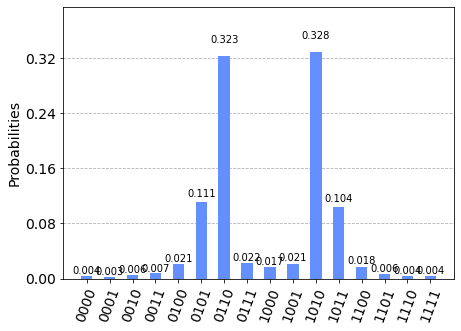

: 

: 

: 

In [ ]:
plot_histogram(counts)

In [ ]:
estimate = sorted(zip(counts.values(), counts.keys()), reverse= True)
for p in range(2): print('p = ',(np.sin(int(estimate[p][1], 2)*pi/(2**precision)))**2 )

p =  0.8535533905932737
p =  0.8535533905932737


: 

: 

: 

In [ ]:
# (np.sin(int('1011',2)*pi/(2**precision)))**2

: 

: 

: 

## Generalised multi-qubit QAE

For the multi qubit case consider a n-qubit system, such that some of its computational basis state are marked 'good' while others are marked 'bad' states. Then the initial state can be expressed as a superpotion of $\ket{good}$ and $\ket{bad}$ states as 
$\begin{equation}
    \ket{\psi_0} = \sqrt{\frac{N-M}{N}}\ket{bad} + \sqrt{\frac{M}{N}}\ket{good}
\end{equation}$
where $N = 2^n$ and $M$ is the no. of 'good' states.$\\$
Our aim here is to estimate the number of 'good' states $M$ using QPE as proposed by Brassard et al ('96) $\\$
As before we assume,
$\begin{align}
    \sqrt{\frac{N-M}{N}} = cos(\frac{\theta}{2}) \\
    \sqrt{\frac{M}{N}} = sin(\frac{\theta}{2})
\end{align}$ 



In [ ]:
# patterns = [[0,1,1],[0,1,0],[1,1,1],[1,0,1],[1,1,0],[0,0,0],[0,0,1]]
patterns = [[0,1,1,1],[0,0,1,0],[1,0,1,1]]
good_states = [ ''.join([str(elem) for elem in pattern]) for pattern in patterns              ]

: 

: 

: 

In [ ]:
## using qiksit Estimation problem module
stateprep = QuantumCircuit(5)
stateprep.h([0,1,2,3])
estimation = EstimationProblem(stateprep, [0,1,2,4], grover_operator= grover(patterns,1), is_good_state= good_states)
precision = 5
ae = AmplitudeEstimation(
    num_eval_qubits=precision,  # the number of evaluation qubits specifies circuit width and accuracy
    quantum_instance= QuantumInstance(stv_simulator) ,
)
rslt = ae.estimate(estimation)
# rslt.estimaation, rslt.mle , 7/8

KeyboardInterrupt: 

: 

: 

: 

: 

In [ ]:
1-rslt.estimation, 1-rslt.mle , len(patterns)/8

(0.4024548, 0.37499998883960317, 0.375)

: 

: 

: 

In [ ]:
## implementation from scratch ~
precision = 3 
preg = QuantumRegister(precision, name='precision_q')
qreg = QuantumRegister(4,name='qreg')
ancilla = AncillaRegister(1, name='ancilla')
creg = ClassicalRegister(precision, name='precison_c')

qc = QuantumCircuit(preg, qreg, ancilla, creg)

qc.h(preg)
qc.h(qreg)
for q in range(precision):
    qc.append(grover(patterns,2**q).to_gate().control(1), [q]+list(range(precision,precision+4)) )

qftgate_inv = QFT(QuantumCircuit(precision, name='QFT')).to_gate().inverse()
qc.barrier()
qc.append(qftgate_inv, list(range(precision)))

qc.decompose(gates_to_decompose= ['grover^1']).draw()


┌───┐                                        ░ ┌─────────┐
precision_q_0: ┤ H ├──────■─────────────────────────────────░─┤0        ├
               ├───┤      │                                 ░ │         │
precision_q_1: ┤ H ├──────┼────────────■────────────────────░─┤1 QFT_dg ├
               ├───┤      │            │                    ░ │         │
precision_q_2: ┤ H ├──────┼────────────┼────────────■───────░─┤2        ├
               ├───┤┌─────┴─────┐┌─────┴─────┐┌─────┴─────┐ ░ └─────────┘
       qreg_0: ┤ H ├┤0          ├┤0          ├┤0          ├─░────────────
               ├───┤│           ││           ││           │ ░            
       qreg_1: ┤ H ├┤1          ├┤1          ├┤1          ├─░────────────
               ├───┤│  grover^1 ││  grover^2 ││  grover^4 │ ░            
       qreg_2: ┤ H ├┤2          ├┤2          ├┤2          ├─░────────────
               └───┘│           ││           ││           │ ░            
      ancilla: ─────┤3          ├┤3          ├┤3          ├─░────────────
                    └───────────┘└───────────┘└───────────┘ ░            
 precison_c: 3/══════════════════════════════════════════════════════════

: 

: 

: 

In [ ]:
# basis_gates = ["h", "ry", "cry", "cx", "ccx", "p", "cp", "x", "s", "sdg", "y", "t", "cz"]
# transpile(qc, basis_gates=basis_gates, optimization_level=2).draw("mpl", style="iqx")

: 

: 

: 

In [ ]:
qc.measure(preg, creg)
job = execute(qc, backend= aer, shots= 2000)
counts = job.result().get_counts()
counts

{'010': 708,
 '101': 172,
 '001': 55,
 '110': 722,
 '100': 76,
 '111': 52,
 '000': 36,
 '011': 179}

: 

: 

: 

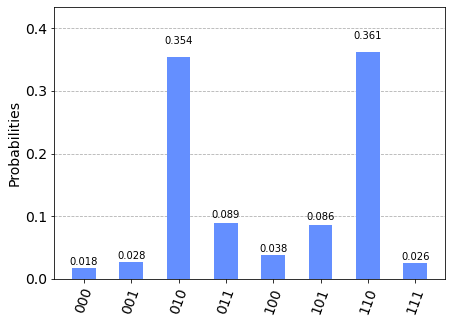

: 

: 

: 

In [ ]:
plot_histogram(counts)

In [ ]:
estimate = sorted(zip(counts.values(), counts.keys()), reverse= True)
for p in range(2): print('p = ',(np.sin(int(estimate[p][1], 2)*pi/(2**precision)))**2 )

p =  0.5000000000000001
p =  0.4999999999999999


: 

: 

: 

In [ ]:
2/8

0.25

: 

: 

: 

: 

: 

: 